In [1]:
%matplotlib inline
import os
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as td
import torch.nn.functional as F
import torchvision as tv
from torchvision import transforms
from utils import *
from PIL import Image
import nntools as nt
import matplotlib.pyplot as plt
from dataloader import *
import glob
from test import *
from models import *
# from scipy.misc import imresize
from matplotlib.pyplot import imread
import torchvision.transforms
# im = imread(image.png)
import cv2

%matplotlib notebook

In [9]:
def target_transform (target, img_size = (224,224) ):
    
    object_to_idx = {'aeroplane': 0,'bicycle': 1,'bird': 2,'boat': 3,
                  'bottle': 4,'bus': 5,'car': 6,'cat': 7,
                  'chair': 8,'cow': 9,'diningtable': 10,'dog': 11,
                  'horse': 12,'motorbike': 13,'person': 14,'pottedplant': 15,
                  'sheep': 16,'sofa': 17,'train': 18,'tvmonitor': 19}
    
    
    h = target['annotation']['size']['height']
    h = float(h)
    w = target['annotation']['size']['width']
    w = float(w)

    if isinstance(target['annotation']['object'], list):
        boxes = [[object_to_idx[x['name']]] + [x['bndbox']['xmin'],x['bndbox']['ymin'],x['bndbox']['xmax'],x['bndbox']['ymax']] for x in target['annotation']['object']]
    elif isinstance(target['annotation']['object'], dict):
        x = target['annotation']['object']['bndbox']
        boxes = [object_to_idx[target['annotation']['object']['name']]] + [x['xmin'],x['ymin'],x['xmax'],x['ymax']]
    else:
        print('I do not know what happened')
        
    boxes = np.array(boxes).astype(np.float)
    boxes = boxes.reshape(-1, 5)
    xmin = boxes[:, 1] / w
    ymin = boxes[:, 2] / h
    xmax = boxes[:, 3] / w
    ymax = boxes[:, 4] / h
    x_center = (xmin + xmax) / 2 
    y_center = (ymin + ymax) / 2 
    box_w = (xmax - xmin) 
    box_h = (ymax - ymin) 
    boxes[:, 1] = x_center
    boxes[:, 2] = y_center
    boxes[:, 3] = box_w
    boxes[:, 4] = box_h
#     boxes[boxes > 1] = 1
#     boxes[boxes < 0] = 0
    targets = torch.zeros(len(boxes), 6)
    targets[:, 1:] = torch.Tensor(boxes)
    targets[targets != targets] = 0
    return targets
img_size = 224
transform = tv.transforms.Compose([
    tv.transforms.Resize((img_size, img_size)),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])
root='data/'
dataset_train = tv.datasets.VOCDetection(root, year='2012', image_set='train',transform = transform, 
                                   target_transform = target_transform, download = True)
#if you have downloaded the dataset before, set download = Flase,else True
dataset_val = tv.datasets.VOCDetection(root, year='2012', image_set='trainval',transform = transform, 
                                   target_transform = target_transform, download = False)

dataset_test = tv.datasets.VOCDetection(root, year='2012', image_set='val',transform = transform, 
                                   target_transform = target_transform, download = False)

dataset_origin = tv.datasets.VOCDetection(root, year='2012', image_set='val',transform = None, 
                                   target_transform = None, download = False)
class VOCDataset(td.Dataset):
  
  def __init__(self, dataset, img_size = (224, 224)):
    super(VOCDataset, self).__init__()
    self.dataset = dataset
    self.img_size = img_size
  
  def collate_fn(self, batch):
    imgs, targets = list(zip(*batch))
    # Remove empty placeholder targets
    targets = [boxes for boxes in targets if boxes is not None]
    # Add sample index to targets
    for i, boxes in enumerate(targets):
        boxes[:, 0] = i
    targets = torch.cat(targets, 0)
    imgs = torch.stack(imgs)
    return imgs, targets

  def __getitem__(self, idx):
    x, d = self.dataset[idx]
    return x, d
  def __len__(self):
    return len(self.dataset)
trainset = VOCDataset(dataset_train)
valset = VOCDataset(dataset_val)
testset = VOCDataset(dataset_test)
object_to_idx = {'aeroplane': 0,'bicycle': 1,'bird': 2,'boat': 3,
              'bottle': 4,'bus': 5,'car': 6,'cat': 7,
              'chair': 8,'cow': 9,'diningtable': 10,'dog': 11,
              'horse': 12,'motorbike': 13,'person': 14,'pottedplant': 15,
              'sheep': 16,'sofa': 17,'train': 18,'tvmonitor': 19}
class_names = list(object_to_idx.keys())

Argument_Dict = {}
Argument_Dict['epochs'] = 100
Argument_Dict['batch_size'] = 8
Argument_Dict['model_def'] = 'config/yolov3-custom.cfg'
Argument_Dict['pretrain_weights'] = 'checkpoints/yolov3.pth' #train start
#59 mAP is 0.55# 71 mAP 0.56
Argument_Dict['yolov3_weights'] = 'weights/yolov3.weights'
Argument_Dict['n_cpu'] = 8
Argument_Dict['gradient_accumulations'] = 2
Argument_Dict['evaluation_interval'] = 1
Argument_Dict['checkpoint_interval'] = 1
Argument_Dict['img_size'] = 224
Argument_Dict['conf_thres'] = 0.8 #object confidence threshold
Argument_Dict['nms_thres'] = 0.4 #iou thresshold for non-maximum suppression"
model = Darknet(Argument_Dict['model_def'], img_size = 224,device=device).to(device)
model.load_state_dict(torch.load(Argument_Dict['pretrain_weights']))

<All keys matched successfully>

In [6]:

dataloader_test = DataLoader(
    dataset = testset,
    batch_size= 1,
    drop_last = True,
    shuffle=False,
)



loader_length = len(dataloader_test)


mini_batch = []
mini_label = []
for batch_i, (local_batch, local_label) in enumerate(dataloader_test):
    mini_batch.append(local_batch)
    mini_label.append(local_label)

5823


[tensor([[1.3719e+01, 3.7013e+00, 2.0875e+02, 2.2547e+02, 9.9995e-01, 5.0050e-01,
         6.0000e+00],
        [2.5552e+01, 2.4850e+01, 2.0814e+02, 2.2153e+02, 9.9979e-01, 1.3317e-01,
         0.0000e+00]])]
	+ Label: car, Conf: 0.50050
tensor(435.3341)
tensor(371.2590)
tensor(30.6224)
tensor(6.1963)


<Figure size 432x288 with 0 Axes>

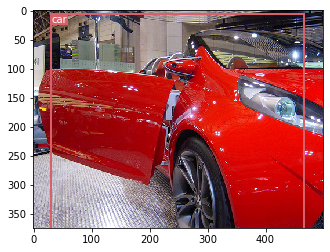

In [14]:
Argument_Dict['plot'] = 7
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

# input_imgs, y = valset[1]
input_imgs = mini_batch[Argument_Dict['plot']]
input_imgs = Variable(input_imgs.type(Tensor))

with torch.no_grad():
    detections = model(input_imgs)
    detections = non_max_suppression(detections, Argument_Dict['conf_thres'], Argument_Dict['nms_thres'])

cmap = plt.get_cmap("tab20b")
colors = [cmap(i) for i in np.linspace(0, 1, 20)] 
detections_ori = detections[0]
print(detections)
test_img = input_imgs.cpu().resize_(3, 224, 224)
unique_labels = detections[0][:, -1].cpu().unique()
n_cls_preds = len(unique_labels)
bbox_colors = random.sample(colors, n_cls_preds)

img, lll = dataset_origin[Argument_Dict['plot']]
test_img_size = [np.size(img)[0], np.size(img)[1]]
im = np.array(img)
plt.figure()
fig, ax = plt.subplots(1)
ax.imshow(im)
original_shape = test_img_size
current_dim = 224
orig_w, orig_h = original_shape

for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections_ori:
    if cls_conf > Argument_Dict['nms_thres']:
        print("\t+ Label: %s, Conf: %.5f" % (class_names[int(cls_pred)], cls_conf.item()))
        x1 = x1 * orig_w / current_dim
        y1 = y1 * orig_h / current_dim
        x2 = x2 * orig_w / current_dim
        y2 = y2 * orig_h / current_dim
        box_w = x2 - x1
        box_h = y2 - y1
        print(box_w)
        print(box_h)
        print(x1)
        print(y1)

        color = bbox_colors[int(np.where(unique_labels == int(cls_pred))[0])]

        # Create a Rectangle patch
        bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor=color, facecolor="none")


        # Add the bbox to the plot
        ax.add_patch(bbox)

        # Add label
        plt.text(
            x1,
            y1,
            s=class_names[int(cls_pred)],
            color="white",
            verticalalignment="top",
            bbox={"color": color, "pad": 0},
        )
# plt.gca().invert_yaxis()
plt.show()